In [1]:
pip install "numpy<=1.21.5" "astropy<=5.0.3" photutils

  Using cached photutils-1.11.0-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Using cached photutils-1.10.0-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Using cached photutils-1.9.0-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
  Using cached photutils-1.8.0-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (854 kB)
Note: you may need to restart the kernel to use updated packages.


# Reduction

In [2]:
import os
from os import listdir
from os.path import isfile, join
from os.path import splitext


from astropy.io import fits
from astropy.stats import sigma_clip
import astropy.units as u
import numpy as np
from astropy.io.fits import getheader
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize, LinearStretch, ZScaleInterval


def create_median_bias(bias_list, median_bias_filename):

    # - - - - Making the list 2D arrays, opening the files - - - - 
    bias_arrays = []
    for bias_file in bias_list:
        with fits.open(bias_file) as hdul:
            bias_data = hdul[0].data
            # - - - - cropping the frame - - - - 
            s_bias_data = bias_data #[2048:3072, 2048:3072]
            bias_arrays.append(s_bias_data) #for mask, s_
            # - - - - Making a header with a brief description of what was done - - - - 
            header = hdul[0].header.copy()
            header['HISTORY'] = 'Median bias created with same units'
        
    # - - - - Sigma crippling algorythm to remove outliers, and then combining the arrays as done in lecture - - - - 
    bias_arrays_masked = sigma_clip(bias_arrays, cenfunc='median', sigma=3, axis=0)
    median_bias = np.ma.getdata(np.median(bias_arrays_masked, axis=0)) # np.ma.getdata inserted in order to make the masked array properly save

    # Here is some code to create a new FITS file from the resulting median bias frame.
    # You can replace the header with something more meaningful with information.
    primary = fits.PrimaryHDU(data=median_bias, header=fits.Header())
    hdul = fits.HDUList([primary])
    hdul.writeto(median_bias_filename, overwrite=True)

    return median_bias

def create_median_dark(dark_list, bias_filename, median_dark_filename):

    # - - - - Reading median bias frame - - - - 
    #bias_file = fits.open('median_bias_filename.fit') # comment out for input
    bias_file = fits.open(bias_filename)
    median_bias_read_array = bias_file[0].data

    # - - - - Creating a 2d array - - - - 
    dark_data_scaled = []
    for dark_file in dark_list:
        with fits.open(dark_file) as hdul:
            dark_data = hdul[0].data
            s_dark_data = dark_data #[2048:3072, 2048:3072]
            # - - - -subtracting the bias frame from each dark image
            dark_no_bias = s_dark_data - median_bias_read_array # for mask, s_
            # - - - - getting exposure time from the header and subtracting
            exptime = hdul[0].header['EXPTIME']
            dark_current_per_second = dark_no_bias / exptime
            # - - - - creating final 2d arrays
            dark_data_scaled.append(dark_current_per_second)
            header = hdul[0].header.copy() # adjust later, want to update header
            header['BUNIT'] = 'electrons/s'

    # - - - - Sigma crippling algorythm to combine and remove outliers - - - - 
    dark_data_scaled_masked = sigma_clip(dark_data_scaled, cenfunc='median', sigma=3, axis=0)
    # - - - - Creating a median array and making sure the masking is properly taken account of to prevent storage errors
    median_dark = np.ma.getdata(np.median(dark_data_scaled_masked, axis=0).filled(fill_value=0))


    # - - - - Save to FITS - - - - 
    primary = fits.PrimaryHDU(data=median_dark, header=header)
    hdul = fits.HDUList([primary])
    #median_dark_filename = 'median_dark_filename.fit' # comment out for input
    hdul.writeto(median_dark_filename, overwrite=True)

    return median_dark


def create_median_flat(
    flat_list,
    bias_filename,
    median_flat_filename,
    dark_filename=None,
):
    # - - - - Checking to see if all filters match - - - - 
    file_filter = fits.getheader(flat_list[0])['FILTER']
    match = all(fits.getheader(f)['FILTER'] == file_filter for f in flat_list)
    print(f"All filters match: {match}")

    # - - - - Reading median bias frame - - - - 
    bias_file = fits.open(bias_filename) # comment out for input
    median_bias_read_array = bias_file[0].data

    # - - - - Creating 2d arrays - - - - 
    flat_array = []
    for flat_file in flat_list:
        with fits.open(flat_file) as hdul:
            flat_data = hdul[0].data
            s_flat_data = flat_data #[2048:3072, 2048:3072]
            # - - - - subtracting the bias frame from each dark image
            flat_no_bias = s_flat_data - median_bias_read_array #for mask, s_
            # - - - - Create actual array
            flat_array.append(flat_no_bias)
            header = hdul[0].header.copy() # edit later for specificity
            
    # - - - - Sigma crippling algorythm to remove outliers - - - - 
    flat_array_masked = sigma_clip(flat_array, cenfunc='median', sigma=3, axis=0)
    # - - - - Creating a median array and making sure the masking is properly taken account of to prevent storage errors.
    un_normalized_median_flat = np.ma.getdata(np.median(flat_array_masked, axis=0).filled(fill_value=0))

    # - - - - Creating normalized flat by dividing the median flat by the median value- - - - 
    median_flat = un_normalized_median_flat / np.median(un_normalized_median_flat)

    # - - - - Saving to fit - - - - 
    primary = fits.PrimaryHDU(data=median_flat, header=header)
    hdul = fits.HDUList([primary])
    #median_flat_filename = 'median_flat_filename.fit' # comment out for input
    hdul.writeto(median_flat_filename, overwrite=True)

    return median_flat

def reduce_science_frame(
    science_filename,
    median_bias_filename,
    median_flat_filename,
    median_dark_filename,
    reduced_science_filename="reduced_science.fits",
):
    # - - - - Reading a science file from name
    science_file = fits.open(science_filename)
    science_read_array = science_file[0].data

    # - - - - Reading median bias from filename
    bias_file = fits.open(median_bias_filename)
    median_bias_read_array = bias_file[0].data

    # - - - - Reading median flat
    flat_file = fits.open(median_flat_filename)
    median_flat_read_array = flat_file[0].data

    # - - - - Reading median dark
    dark_file = fits.open(median_dark_filename)
    median_dark_read_array = dark_file[0].data

    # - - - - Subtracting bias frame from the science frame
    s_science_read_array = science_read_array #[2048:3072, 2048:3072] # Cropping Science array to 1024, centered on image (same for bias, dark, flat)
    science_no_bias = s_science_read_array - median_bias_read_array # for mask s_

    # - - - - Multiplying the dark array by the science frame's exposure time
    exptime = science_file[0].header['EXPTIME']
    dark_with_exptime = median_dark_read_array * exptime
    # - - - - Subtracting dark (with exposure time) from science frame
    science_no_bias_no_dark = science_no_bias - dark_with_exptime

    # - - - - Correcting the science frame with the flat: dividing as seen in the course website
    normalized_flat = median_flat_read_array / np.median(median_flat_read_array)
    reduced_science = science_no_bias_no_dark / normalized_flat

    # removing cosmic rays: optional so skipped

    # - - - - Saving final file as reduced_science_filename
    header = science_file[0].header
    primary = fits.PrimaryHDU(data=reduced_science, header=header)
    hdul = fits.HDUList([primary])
    hdul.writeto(reduced_science_filename, overwrite=True)

    return reduced_science


def calculate_gain(files, median_bias_filename):
    # - - - - Read median bias
    with fits.open(median_bias_filename) as hdul:
        median_bias = hdul[0].data
    
    # - - - - Read and process flats. Subtract bias from the flats
    with fits.open(files[0]) as hdul1, fits.open(files[1]) as hdul2:
        flat1 = hdul1[0].data - median_bias
        flat2 = hdul2[0].data - median_bias
 
    # - - - - Calculate mean signal by taking the mean of the average of the flats (should return one value)
    mean_signal = np.mean((flat1 + flat2)/2)
    
    # - - - - Calculate variance of the difference (to get counts per pixel)
    var_diff = np.var(flat1 - flat2)
    
    # - - - - Gain calculation
    gain = mean_signal / (var_diff / 2)  # in e-/ADU; see return statement.
    
    return gain * u.electron/u.adu


def calculate_readout_noise(files, gain):
    # - - - - Getting the variation of the bias - - - - 
    bias_read_arrays = []
    for f in files:
        with fits.open(f) as hdul:
            bias_data = hdul[0].data
            s_bias_data = bias_data#[2048:3072, 2048:3072]
            bias_clean = s_bias_data - np.median(s_bias_data, axis=0) # Was getting unreasonable error, so subtracting the median bias arrays in an attempt to remove the noise that is making what should be a mathematically accurate function incorrect 

            bias_read_arrays.append(bias_clean)

    # - - - - setting bias_std_diff, using the denominator code from the gain function but redefining it for bias. Paying special care to be std, not var()/2 - - - -         
    if len(bias_read_arrays) > 2:
        bias_difference = bias_read_arrays[0]-np.mean(bias_read_arrays[1:], axis=0)
    else:
        bias_difference = bias_read_arrays[0]-bias_read_arrays[-1]
    bias_std_diff = (np.std(bias_difference)) * u.adu

    # - - - - Readnoise equation - - - 
    readout_noise = gain * bias_std_diff / np.sqrt(2)

    print(readout_noise)
    
def run_reduction(data_dir, star, flat_filter):
    # - - - - following the same reduction process as in the ccd reductions assignment. FIRST, reading the file and creating bias, dark, flat (for target band), and science (for target star) lists 
    bias_list = [join(data_dir, f) for f in listdir(data_dir) if isfile(join(data_dir, f)) and f.startswith('Bias_') and f.lower().endswith('.fits')]
    dark_list = [join(data_dir, f) for f in listdir(data_dir) if isfile(join(data_dir, f)) and f.startswith('Dark_') and f.lower().endswith('.fits')]
    flat_list = [join(data_dir, f) for f in listdir(data_dir) if isfile(join(data_dir, f)) and f.startswith(flat_filter) and f.lower().endswith('.fits')]
    science_list = [join(data_dir, f) for f in listdir(data_dir) if isfile(join(data_dir, f)) and f.startswith(star) and f.lower().endswith('.fits')]
    # - - - - setting up filenames just like in the assignment
    median_bias_filename = 'median_bias_filename.fits'
    bias_filename = 'median_bias_filename.fits'
    median_flat_filename = 'median_flat_filename.fits'
    median_dark_filename = 'median_dark_filename.fits'
    reduced_science_filename = 'reduced_science_filename.fits'
    science_filename=science_list

    # - - - - Running reduction process like in the assignment
    create_median_bias(bias_list, median_bias_filename)
    create_median_dark(dark_list, bias_filename=median_bias_filename, median_dark_filename=median_dark_filename)
    create_median_flat(flat_list, bias_filename=median_bias_filename, median_flat_filename=median_flat_filename, dark_filename=None,)
    # - - - - For science files, running it such that it processes all science files instead of one (as was the case in the ccd assignment)
    for science_file in science_list:
        original_name = os.path.basename(science_file)
        output_name = f'{original_name}_out.fits' # creating an output name to save the reduced files to, in order to perform analysis on. When I rewrite everything for RR Lyrae in zip files, I do not save the files
        reduce_science_frame(science_file, median_bias_filename, median_flat_filename, median_dark_filename,reduced_science_filename=output_name)
    calculate_readout_noise(files=bias_list, gain=calculate_gain(files=flat_list, median_bias_filename='median_bias_filename.fits')) # function adjusted to only use two bias files, so no need in defining a set of two files here.
    print(calculate_gain(files=flat_list, median_bias_filename='median_bias_filename.fits')) # calculate_readout_noise already prints itself, so print statement for gain moved here. Gain function adjusted to only read two flat files, so no need in defining a set of two files here. 

In [3]:
run_reduction(data_dir= '/home/jovyan/work/May_27_Unreduced_Data/', star= 'CY UMa_V_', flat_filter= 'domeflat_V')

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


All filters match: True
12.280326341788337 electron
1.324686831071029 electron / adu


# Analysis

In [4]:
from astropy.time import Time
from astropy.io import fits
import astropy.units as u
import photutils
from photutils.aperture import CircularAperture
from photutils.aperture import CircularAnnulus
from photutils.aperture import aperture_photometry
from photutils.aperture import ApertureStats
from astropy.table import QTable, Table, Column
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from photutils.detection import find_peaks



def do_aperture_photometry(
    image,
    radii,
    sky_radius_in,
    sky_annulus_width,
):
    # - - - - Reading image - - - - 
    image_file = fits.open(image)
    image_read_array = image_file[0].data
    # - - - - Setting up data, and preparing for unit of flux - - - - 
    data = u.Quantity(image_read_array, unit='adu')
    time_obs = Time(image_file[0].header['DATE-OBS'])

    
    # - - - - NEW independent of CCD assignment: Finding the star central to the image, strict enough to filter out other stars without removing original - - - - 
    center_x, center_y = 513, 513 # 513 determined by zooming into central CCD pixel on ARCSAT output files. Note that this means this is only compatible with our files, as different pixel centers make this line inaccurate
    cropped_data = data[center_y-100:center_y+100, center_x-100:center_x+100] # creating region guarenteed to only contain central star
    peaks = find_peaks(data=cropped_data.value, threshold=200, box_size=11) # using find_peaks... to find peaks (flux). threshold is set at 200 since we are dealing with variable stars. Some files' central star flux gets close to the background with cloud coverage 
    x_star = peaks['x_peak'][0] + center_x - 100 # determining the x and y positions of the star based on the highest flux vale and center of the ccd (-100s to convert back into the region of the entire ccd)
    y_star = peaks['y_peak'][0] + center_y - 100    
    positions = [(x_star, y_star)]
    
    
    # - - - - Reading positions as tuples
    x_y_positions = tuple(map(tuple, positions))
    
    # - - - - defining apertures with each position and radius, using for loop to isolate radius. Using CircularAperture due to dealing with x,y pixel positions - - - - 
    apertures = [CircularAperture(x_y_positions, r=r) for r in radii]
    
    # - - - - defining the sky also with CircularAnnulus, due to using pixel measurments. r_in defined by sky_radius_in, and r_out using sky_radius_in plus the width in order to return the combined radius - - - -  
    sky_annulus = CircularAnnulus(x_y_positions, r_in = sky_radius_in, r_out = sky_radius_in + sky_annulus_width)
    
    # - - - - getting the median value of the data, to be used as the background sky (once scaled to area of the aperture) - - - - 
    sky_stats = ApertureStats(data, sky_annulus)
    sky_values = sky_stats.median

    # - - - - for each aperture defined by each radius, first measuring the flux through aperture_photometry as hinted, then subtracting the sky background found earlier (scaled to area), and finally creating a list of final sky-less fluxes - - - - 
    final_fluxes = []
    for ap in apertures:
        measured_flux = aperture_photometry(data, ap)['aperture_sum']
        flux_without_sky_background = measured_flux - (sky_values * ap.area)
        final_fluxes.append(flux_without_sky_background)

    # - - - - Setting up a table. Previously flux was taken for each aperture. Since my new goal is to plot one point for each star, I only want the maximum flux value (represents the truest value for our data and purpouses) - - - - 
    optimal_flux = np.argmax(final_fluxes)
    
    return Table({
        'time': [time_obs.mjd], # takes time from the header, at the beginning of the function, and the peak flux of the data, creating a 1x2 table specfic to the input science image
        'flux': [float(final_fluxes[optimal_flux].value)] 
    })




from os import listdir
from os.path import isfile, join
from astropy.table import vstack


def plot_light_curve(mypath, start_with): 
    # - - - - creates a simple time vs flux table based on every science file with the same star name (all data used was under one filter per star) - - - - 
    # - - - - defining variables to pass to do_aperture_photometry. Borrowed from the CCD assignment.
    data_list = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f)) and f.startswith(start_with) and f.lower().endswith('.fits')]
    radii = [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0]
    sky_radius_in = 15.0
    sky_annulus_width = 10.0

    plt.figure(figsize=(14, 7))
    
    # - - - - Creating a table by running do_aperture_photometry on every science image in data_list. all 1x2 tables are combined with vstack to make a flux table for the star over the entire observing period - - - -
    flux_table = []
    for data_file in data_list:
            flux_data = do_aperture_photometry(data_file, radii, sky_radius_in, sky_annulus_width)
            flux_table.append(flux_data)
    flux_table = Table(vstack(flux_table))
    flux_table.sort('time') # Making the data chronological, according to the time listed in the table
    t_start = Time(flux_table['time'][0], format='mjd') # getting the time of the first entry. 
    flux_table['hours'] = [(Time(t, format='mjd') - t_start).sec / 3600 
                          for t in flux_table['time']] # Personal choice to make all tables start at 0, so subtracting the start time from each entry. Also converting to hours for interpretation.
    flux = flux_table['flux']
    flux_table['norm_flux'] = flux / np.median(flux) # normalizing the flux for interpretation
    plt.plot(flux_table['hours'], flux_table['norm_flux'], 'o-')
    plt.ylabel('Normalized Flux (ADU)')
    plt.xlabel(f'Time since beginning of observation (hours)')
    plt.title(f'{(mypath)[18:-1]} Light Curve') # making the title isolate the star name based on the path used. NOTE this will only work as intended for my specific attempt, since I ran everything out of my own jupytr with my own name and directories
    plt.tight_layout()
    plt.savefig(f'{(mypath)[18:-1]} Light Curve') # same as plot title
    plt.show()
    return flux_table # output shows the plot and returns the flux table, so later I can run this in a different function and use the table, output that function's table, and output this function's table all at once. 

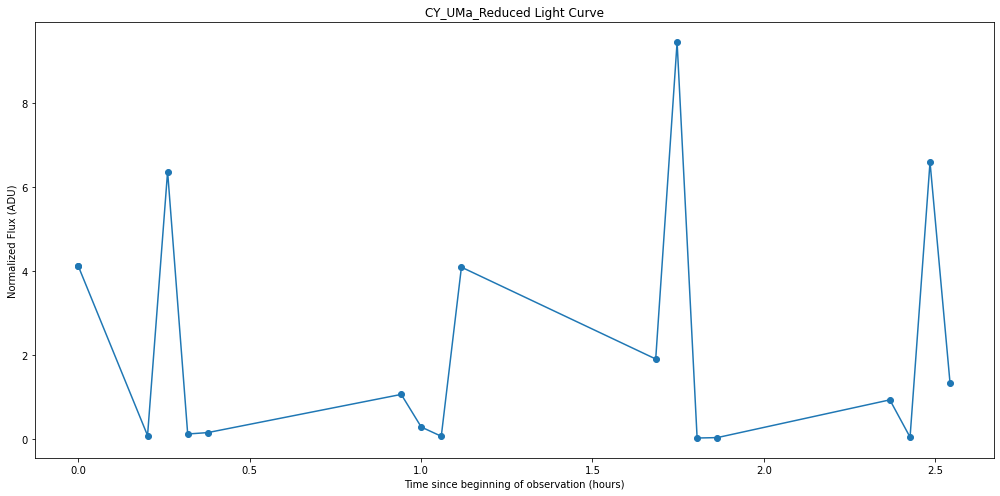

time,flux,hours,norm_flux
float64,float64,float64,float64
60822.175907164354,1261.1612136811018,0.0,4.123352857035716
60822.175907164354,1261.1612136811018,0.0,4.123352857035716
60822.184339444444,26.61380109012339,0.2023747221683152,0.08701353290213774
60822.186776041664,1947.4846287994296,0.2608530554571189,6.367279790309015
60822.18921895833,37.68896114514018,0.319483055442106,0.12322364811943673
60822.191650925924,47.80084624850463,0.3778502776985988,0.15628434637011865
60822.21517025463,325.7146220486611,0.9423141666920856,1.0649204105179977
60822.217602083336,88.3721288772067,1.0006780555704609,0.28893171319832434
60822.22003576389,21.21286628696305,1.0590863887919113,0.06935523536674745


In [5]:
plot_light_curve(mypath = '/home/jovyan/work/CY_UMa_Reduced/', start_with='CY')

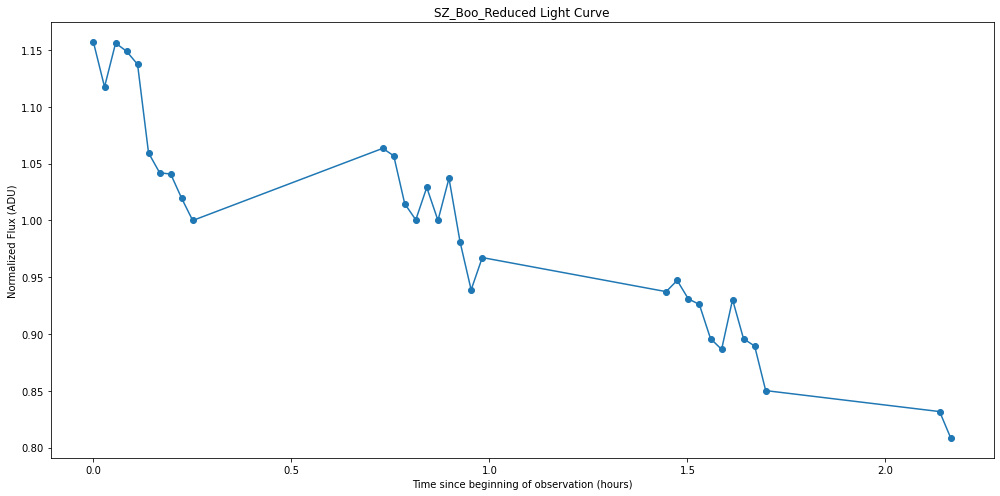

time,flux,hours,norm_flux
float64,float64,float64,float64
60822.198672094906,228589.44730087224,0.0,1.1569503214107455
60822.199840277775,220804.56862894067,0.028036388859618455,1.1175490367583525
60822.20100462963,228434.55415039422,0.055980833305511624,1.1561663671103792
60822.20215509259,227015.06015915005,0.08359194447984919,1.1489819408439779
60822.20331550926,224732.92046379103,0.11144194443477318,1.1374314415307938
60822.20446956019,209333.9239857663,0.1391391667420976,1.0594931371382723
60822.20564107639,205868.84093515022,0.1672555556287989,1.041955455515338
60822.20680195602,205650.6172564082,0.19511666666949168,1.0408509690298893
60822.20795509259,201427.33156842605,0.22279194445582107,1.0194758277369966


In [6]:
plot_light_curve(mypath = '/home/jovyan/work/SZ_Boo_Reduced/', start_with='SZ Boo_V_')

In [7]:
#plot_light_curve(mypath = '/home/jovyan/work/RR_Lyrae_2_sec_Reduced/', start_with='reduced')

# RRLyrae Specific Code (to avoid downloading 4GB on 1GB space):

In [10]:
def create_median_bias_RR(bias_list, median_bias_filename):
    # - - - - the fits open file process has been removed; as processing zip files (and also for the sake of clarity) the zip opening files has been moved to the full reduction function. Here, focusing on extracting data from the files. NOTE median bias, dark, flat files ARE saved as fits files because they are required for the CCD reduction pipeline
    bias_arrays = [data for data, header in bias_list]

    # - - - - Sigma crippling algorythm to remove outliers, and then combining the arrays as done in lecture - - - - 
    bias_arrays_masked = sigma_clip(bias_arrays, cenfunc='median', sigma=3, axis=0)
    median_bias = np.ma.getdata(np.median(bias_arrays_masked, axis=0)) # np.ma.getdata inserted in order to make the masked array properly save

    # Here is some code to create a new FITS file from the resulting median bias frame.
    # You can replace the header with something more meaningful with information.
    primary = fits.PrimaryHDU(data=median_bias, header=fits.Header())
    hdul = fits.HDUList([primary])
    hdul.writeto(median_bias_filename, overwrite=True)

    return median_bias



def create_median_dark_RR(dark_list, bias_filename, median_dark_filename):

    # - - - - Reading median bias frame - - - - 
    #bias_file = fits.open('median_bias_filename.fit') # comment out for input
    bias_file = fits.open(bias_filename)
    median_bias_read_array = bias_file[0].data
    bias_file.close()

    # - - - - Creating a 2d array - - - -
    # just like in bias, re-adapted for the new zip method. doing the same data manipulations as in create_median_dark
    dark_data_scaled = []
    for data, header in dark_list:        
        # - - - -subtracting the bias frame from each dark image
        dark_no_bias = data - median_bias_read_array 
        # - - - - getting exposure time from the header and subtracting
        exptime = header['EXPTIME']
        dark_current_per_second = dark_no_bias / exptime
        # - - - - creating final 2d arrays
        dark_data_scaled.append(dark_current_per_second)

    # - - - - Sigma crippling algorythm to combine and remove outliers - - - - 
    dark_data_scaled_masked = sigma_clip(dark_data_scaled, cenfunc='median', sigma=3, axis=0)
    # - - - - Creating a median array and making sure the masking is properly taken account of to prevent storage errors
    median_dark = np.ma.getdata(np.median(dark_data_scaled_masked, axis=0).filled(fill_value=0))


    # - - - - Save  - - - - 
    header = dark_list[0][1].copy()
    header['BUNIT'] = 'electrons/s'
    primary = fits.PrimaryHDU(data=median_dark, header=header)
    hdul = fits.HDUList([primary])
    #median_dark_filename = 'median_dark_filename.fit' # comment out for input
    hdul.writeto(median_dark_filename, overwrite=True)

    return median_dark


def create_median_flat_RR(
    flat_list,
    bias_filename,
    median_flat_filename,
    dark_filename=None,
):
    # - - - - Checking to see if all filters match - - - - 
    file_filter = flat_list[0][1]['FILTER']
    match = all(header['FILTER'] == file_filter for data, header in flat_list)
    print(f"All filters match: {match}")

    # - - - - Reading median bias frame - - - - 
    bias_file = fits.open(bias_filename) # comment out for input
    median_bias_read_array = bias_file[0].data
    bias_file.close()

    # - - - - Creating 2d arrays - - - - 
    # just like in bias, re-adapted for the new zip method. doing the same data manipulations as in create_median_flat
    flat_array = []
    for data, header in flat_list:        
        # Subtracting the bias frame from each flat image
        flat_no_bias = data - median_bias_read_array
        # Create actual array
        flat_array.append(flat_no_bias)
            
    # - - - - Sigma crippling algorythm to remove outliers - - - - 
    flat_array_masked = sigma_clip(flat_array, cenfunc='median', sigma=3, axis=0)
    # - - - - Creating a median array and making sure the masking is properly taken account of to prevent storage errors.
    un_normalized_median_flat = np.ma.getdata(np.median(flat_array_masked, axis=0))

    # - - - - Creating normalized flat by dividing the median flat by the median value- - - - 
    median_flat = un_normalized_median_flat / np.median(un_normalized_median_flat)

    # - - - - Saving to fit - - - - 
    header = flat_list[0][1].copy()
    primary = fits.PrimaryHDU(data=median_flat, header=header)
    hdul = fits.HDUList([primary])
    #median_flat_filename = 'median_flat_filename.fit' # comment out for input
    hdul.writeto(median_flat_filename, overwrite=True)

    return median_flat

def reduce_science_frame_RR(
    science_data,
    science_header,
    median_bias_filename,
    median_flat_filename,
    median_dark_filename,
    reduced_science_filename,
):
    # - - - - Reading the science files that went through the load fits from zip function into an array
    science_read_array = science_data
 

    # - - - - Reading median bias from filename
    with fits.open(median_bias_filename) as bias_file:
        median_bias_read_array = bias_file[0].data
    # - - - - Reading median flat
    with fits.open(median_flat_filename) as flat_file:
        median_flat_read_array = flat_file[0].data
    # - - - - Reading median dark
    with fits.open(median_dark_filename) as dark_file:
        median_dark_read_array = dark_file[0].data
    # - - - - Subtracting bias frame from the science frame
    science_no_bias = science_read_array - median_bias_read_array # for mask s_

    # - - - - Multiplying the dark array by the science frame's exposure time
    exptime = science_header['EXPTIME']
    dark_with_exptime = median_dark_read_array * exptime
    # - - - - Subtracting dark (with exposure time) from science frame
    science_no_bias_no_dark = science_no_bias - dark_with_exptime

    # - - - - Correcting the science frame with the flat: dividing as seen in the course website
    reduced_science = science_no_bias_no_dark / median_flat_read_array
    # removing cosmic rays: optional so skipped

    # - - - - Saving final file as reduced_science_filename # commented out the saving process as there are around 500 RR Lyrae files and I do not want to save every science file
    #header = science_filename[0].header
    #primary = fits.PrimaryHDU(data=reduced_science, header=header)
    #hdul = fits.HDUList([primary])
    #hdul.writeto(reduced_science_filename, overwrite=True)

    return reduced_science

def calculate_gain_RR(files, median_bias_filename): # kept effectively the same; removed comments from calculate_gain for the sake of clarity, but refer back for gain specific comments
    # - - - - Read median bias
    with fits.open(median_bias_filename) as hdul:
        median_bias = hdul[0].data
        
    # - - - - Read and process flats
    flat1_data, flat1_header = files[0]
    flat2_data, flat2_header = files[1]
    
    # - - - - Calculate mean signal
    mean_signal = np.mean((flat1_data + flat2_data)/2)
    
    # - - - - Calculate variance of the difference
    var_diff = np.var(flat1_data - flat2_data)
    
    # - - - - Gain calculation
    gain = mean_signal / (var_diff / 2)
    
    return gain * u.electron/u.adu


def calculate_readout_noise_RR(files, gain): # kept effectively the same; removed comments from calculate_gain for the sake of clarity, but refer back for gain specific comments
    # - - - - Getting the variation of the bias - - - - 
    bias_read_arrays = []
    for data, header in files:
        bias_clean = data - np.median(data, axis=0)
        bias_read_arrays.append(bias_clean)
        bias_read_arrays.append(bias_clean)

    # - - - - setting bias_std_diff, using the denominator code from the gain function but redefining it for bias. Paying special care to be std, not var()/2 - - - -         
    if len(bias_read_arrays) > 2:
        bias_difference = bias_read_arrays[0]-np.mean(bias_read_arrays[1:], axis=0)
    else:
        bias_difference = bias_read_arrays[0]-bias_read_arrays[-1]
    bias_std_diff = (np.std(bias_difference)) * u.adu

    # - - - - Readnoise equation - - - 
    readout_noise = gain * bias_std_diff / np.sqrt(2)

    print(readout_noise)
    
def do_aperture_photometry_RR(
    image_data,
    image_header,
    radii,
    sky_radius_in,
    sky_annulus_width,
):
    # - - - - Reading image - - - - 
    #image_file = fits.open(image) # removing the fits open function because the run reduction pipeline will already send it reduced science files
    
    # - - - - Setting up data, and preparing for unit of flux - - - - 
    data = u.Quantity(image_data, unit='adu')
    time_obs = Time(image_header['DATE-OBS'])

    
    # - - - - NEW: Finding the star central to the image, strict enough to filter out other stars without removing original. See do_aperture_photometry for comment - - - - 
    #center_x, center_y = 513, 513
    #cropped_data = data[center_y-100:center_y+100, center_x-100:center_x+100]
    #peaks = find_peaks(data=cropped_data.value, threshold=1000, box_size=11)
    #x_star = peaks['x_peak'][0] + center_x - 100
    #y_star = peaks['y_peak'][0] + center_y - 100    
    #positions = [(x_star, y_star)]
    
    try: # I was encountering an error with my original method of locating the central star. Here, I coded alternatives but kept the first iteration (still used in the do_aperture_photometry function) for convenience
        # - - - - automatic detection method: locating the central star from the mean flux and standard deviation to define the find_peaks function (and threshold of that function)
        mean_val = np.mean(image_data)
        std_val = np.std(image_data)
        threshold = mean_val + 5*std_val  # Dynamic threshold
        peaks = find_peaks(data=image_data, threshold=threshold, box_size=11)
        
        if len(peaks) == 0:  # I was encountering errors running on my initial method from do_aperture_photometry so I attempted the previous method. However, still got some issues, So I attempted the following if else and except. I believe the issue was the cloud coverage at the end of the night, because the central star effectively falls to roughly the same flux as the rest of the sky on all frames at this part of the night.
            center_x, center_y = 513, 513 
            positions = [(center_x, center_y)]
        else:
            brightest = np.argmax(peaks['peak_value']) # Get brightest peak of the whole dataset. In the frames I checked for RR Lyrae no stars were brighter than the target, but this method would fail if that were not the case. I made sure to double-check the frames at the end of the night, but as you will see later, I removed the last 30 frames when the cloud coverage was too extreme so there is no need to worry about this fall back selecting the wrong star
            x_star = peaks['x_peak'][brightest]
            y_star = peaks['y_peak'][brightest]
            positions = [(x_star, y_star)]
            
    except Exception as e:
        print(f"Star finding failed: {str(e)}") # all else fails situation, to make absolutely sure no error messages would appear and we know if it failed. Completes the try, except arguments.
        center_x, center_y = 513, 513
        positions = [(center_x, center_y)]

    
    
    # - - - - Reading positions as tuples; No changes from do_aperture_photometry, so refer to that function for comment.
    x_y_positions = tuple(map(tuple, positions))
    
    # - - - - defining apertures with each position and radius, using for loop to isolate radius. Using CircularAperture due to dealing with x,y pixel positions - - - - 
    apertures = [CircularAperture(x_y_positions, r=r) for r in radii]
    
    # - - - - defining the sky also with CircularAnnulus, due to using pixel measurments. r_in defined by sky_radius_in, and r_out using sky_radius_in plus the width in order to return the combined radius - - - -  
    sky_annulus = CircularAnnulus(x_y_positions, r_in = sky_radius_in, r_out = sky_radius_in + sky_annulus_width)
    
    # - - - - getting the median value of the data, to be used as the background sky (once scaled to area of the aperture) - - - - 
    sky_stats = ApertureStats(data, sky_annulus)
    sky_values = sky_stats.median

    # - - - - for each aperture defined by each radius, first measuring the flux through aperture_photometry as hinted, then subtracting the sky background found earlier (scaled to area), and finally creating a list of final sky-less fluxes - - - - 
    final_fluxes = []
    for ap in apertures:
        measured_flux = aperture_photometry(data, ap)['aperture_sum']
        flux_without_sky_background = measured_flux - (sky_values * ap.area)
        final_fluxes.append(flux_without_sky_background)

    # - - - - Setting up a table. Creating a star label to distinguish, and later use in the labels for the plots - - - - 
    optimal_flux = np.argmax(final_fluxes)
    
    return Table({
        'time': [time_obs.mjd], 
        'flux': [float(final_fluxes[optimal_flux].value)]
    })


In [28]:
import os
import zipfile
from astropy.io import fits
from io import BytesIO
from astropy.table import vstack

def load_fits_from_zip(zip_file, file_list):
    # - - - - Load FITS data from given filenames in the zip
    data_list = []
    for name in file_list:
        with zip_file.open(name) as f: # zip open command, running functions nearly identical to the fits open ones seen in the ccd reductions assignment
            hdul = fits.open(BytesIO(f.read()))
            data = hdul[0].data
            header = hdul[0].header
            data_list.append((data, header))
            hdul.close()
    return data_list

def process_observations(zip_path, star, flat_filter, output_dir='/home/jovyan/work/'):
    # - - - - creating the reduction pipeline for RR Lyrae, and merging it with plot_light_curve (which you will notice doesn't have an _RR equivalent)
    median_bias_filename = 'median_bias_28.fits'
    median_flat_filename = 'median_flat_28.fits'
    median_dark_filename = 'median_dark_28.fits'

    # - - - - creating bias/dark/flat lists based on zip files (notice use of load_fits_from_zip files) - - - - 
    with zipfile.ZipFile(zip_path, 'r') as z:
        names = z.namelist()
    
        bias_files = [f for f in names if 'Bias_' in f and f.endswith('.fits')]
        dark_files = [f for f in names if 'Dark_' in f and f.endswith('.fits')]
        flat_files = [f for f in names if flat_filter in f and f.endswith('.fits')] # filter specific so that we make sure star and flats for the filter star was observed with match
        science_files = [f for f in names if 'RRLyrae' in f and f.endswith('.fits')]
        
        bias_list = load_fits_from_zip(z, bias_files)
        dark_list = load_fits_from_zip(z, dark_files)
        flat_list = load_fits_from_zip(z, flat_files)

    reduced_science_filename = 'reduced_science_filename.fits'
    science_filename=science_files

    # - - - - running functions that create the median files - - - - 
    median_bias = create_median_bias_RR(bias_list, median_bias_filename)
    median_dark = create_median_dark_RR(dark_list, bias_filename=median_bias_filename, median_dark_filename=median_dark_filename)
    median_flat = create_median_flat_RR(flat_list, bias_filename=median_bias_filename, median_flat_filename=median_flat_filename, dark_filename=None,)
    
    
    radii = [1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0]
    sky_radius_in = 15.0
    sky_annulus_width = 10.0

    # - - - - Doing reduce_science_frame_RR and do_aperture_photometry_RR on each science zip file. Remember that science didn't save the files. the data is sent to do_aperture_photometry_RR, so the saving is unecessary! - - - - 
    photometry_results = []
    with zipfile.ZipFile(zip_path, 'r') as z:
        for science in science_files:
            with z.open(science) as f:
                hdul = fits.open(BytesIO(f.read()))
                reduced_science = reduce_science_frame_RR(science_data=hdul[0].data, science_header=hdul[0].header,median_bias_filename=median_bias_filename,median_flat_filename=median_flat_filename,median_dark_filename=median_dark_filename,reduced_science_filename=None)        
                ap_phot_table = do_aperture_photometry_RR(image_data=reduced_science, image_header=hdul[0].header,radii=radii, sky_radius_in=sky_radius_in, sky_annulus_width=sky_annulus_width)
                photometry_results.append(ap_phot_table)
                base_filename = os.path.basename(science)
                hdul.close()
    # - - - - Creating a table out of the results, identical function to when I was making the flux_table. 
    final_table = vstack(photometry_results)
    
    calculate_readout_noise_RR(files=bias_list[:2], gain=calculate_gain_RR(files=flat_list, median_bias_filename=median_bias_filename)) # reporting readout noise for the reduction
    print(calculate_gain_RR(files=flat_list[:2], median_bias_filename=median_bias_filename)) # reporting gain for the reduction

    
    # - - - - Everything below here is identical in function to the plot_light_curve function, just using final table as established above. Check plot_light_curve for commentary - - - -
    final_table.sort('time')
    final_table = final_table[:-30] # removing last 30 frames where cloud coverage is too much and flux drops towards zero
    
    flux = final_table['flux']
    final_table['norm_flux'] = flux / np.median(flux)
    clipped = sigma_clip(final_table['norm_flux'], sigma=3)
    final_table = final_table[~clipped.mask]

    t_start = Time(final_table['time'][0], format='mjd')
    final_table['hours'] = [(Time(t, format='mjd') - t_start).sec / 3600 
                          for t in final_table['time']]
    plt.plot(final_table['hours'], final_table['norm_flux'])
    plt.ylabel('Normalized Flux (ADU)')
    plt.xlabel(f'Time since beginning of observation (hours)')
    plt.title(f'RRLyrae Light Curve')
    plt.tight_layout()
    plt.savefig(f'RR Lyrae Light Curve')
    plt.show()
    return final_table

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


All filters match: True
9.761427546423631 electron
1.2256616257811994 electron / adu


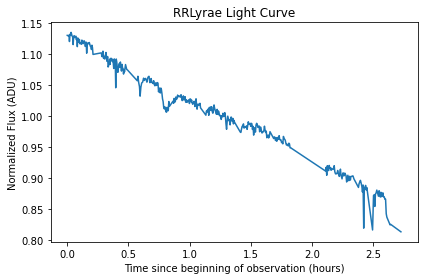

time,flux,norm_flux,hours
float64,float64,float64,float64
60824.32416630787,1219113.669502552,1.1299537059806193,0.0
60824.324357743055,1218944.4166819125,1.1297968314768603,0.0045944443554617465
60824.32456550926,1217714.6942290962,1.1286570448616757,0.009580833313520998
60824.32475126157,1219509.7672462664,1.1303208350881317,0.014038888737559319
60824.324915509256,1208387.8111741,1.12001228405152,0.01798083318863064
60824.32510623842,1221142.5942577824,1.13183424518191,0.022558333177585155
60824.325280439814,1219157.7559158665,1.1299945681310113,0.02673916658386588
60824.32545900463,1224330.2057645211,1.1347887304980622,0.031024722091387957
60824.32563275463,1221476.1828474533,1.1321434367467333,0.035194722237065434


In [29]:
process_observations(zip_path='/home/jovyan/work/May 28 Observations-20250610T233053Z-1-001.zip', star="RRLyrae", flat_filter="domeflat_g", output_dir='/home/jovyan/work/paper-grachiel-new/src/')

In [17]:
def get_periodogram(t, y_obs, name):
    # - - - - - - - - Part 2: Lomb_Scargle to get the period - - - - - - - - 
    # based on example used in ASTR 324: just using standard equations and plugging them into standard functions
    from astroML.time_series import lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap
    from astropy.timeseries import LombScargle
    
    # - - - - for Lomb Scargle, setting up desired statistical variables - - - -
    
    sigma_y = np.std(y_obs) # standard deviation of the flux. Idea is to take the flux column of the flux vs time table I created (so y_obs will be the flux component and t the time component)
    max_time = (t[-1])/24 # to be used for a dynamic x-axis bound and setting up the range for the period linspace (and hence why max_time is divided by 24, to remain consistent with the scale of the linspace (0 to 1, 24h ->1)
    period = np.linspace(0.03, max_time, 10000) # setting up linspace for the period
    omega = 2 * np.pi / period 

    # - - - - Setting up the Lomb Scargle function. This version is based on the astropy version, while the original code I made was based on the astroML version (astroML version was not working in this notebook so the alternative astropy version was created). Only commenting out the astroML version for preference
    #PS = lomb_scargle(t, y_obs, omega, generalized=True) #astroML version
    ls = LombScargle(t, y_obs, dy=sigma_y) # astropy version
    PS=ls.power(omega) # asrtropy Version
    P_fit = period[np.argmax(PS)] # Lomb Scargle predicted period based on the maximum peak in the data
    #D = lomb_scargle_bootstrap(t, y_obs, omega, generalized=True,N_bootstraps=500, random_state=0) # astroML version
    n_bootstraps=500 # part of astroML version
    D = np.zeros((n_bootstraps, len(omega))) # the following lines are all part of the astropy version. Setting up lomb_scargle_bootstrap function based on bootstraps manually becaue the function does not traditionally accept N_bootstraps as a variable
    for i in range(n_bootstraps): # "..."
        np.random.seed(i) # "..."
        y_shuffle = np.random.permutation(y_obs) # "..."
        D[i] = LombScargle(t, y_shuffle, dy=sigma_y).power(omega) # "..."
    sig1, sig5 = np.percentile(D, [99, 95]) # getting the probabilistic regions, to later be used to visually demonstrate where the percentiles lie
    
    plt.figure(figsize=(14, 7))
    plt.plot(period, PS, '-', c='black', lw=1, zorder=1)
    plt.plot([period[0], period[-1]], [sig1, sig1], ':', c='black', label="99% significance level") # making 99 significance level line based on the data
    plt.plot([period[0], period[-1]], [sig5, sig5], '-.', c='black', label="95% significance level") # same but for 95
    plt.xlabel('Period (days)')
    plt.ylabel('Lomb-Scargle Power')
    plt.legend()
    caption = (f"The most likely period (the highest periodogram peak), P_fit, is {P_fit:.3f} days")
    plt.text(0.5, 0.95, caption, transform=plt.gca().transAxes, ha='center', fontsize=12)
    plt.savefig(f'{name} periodogram.png')
    plt.show()


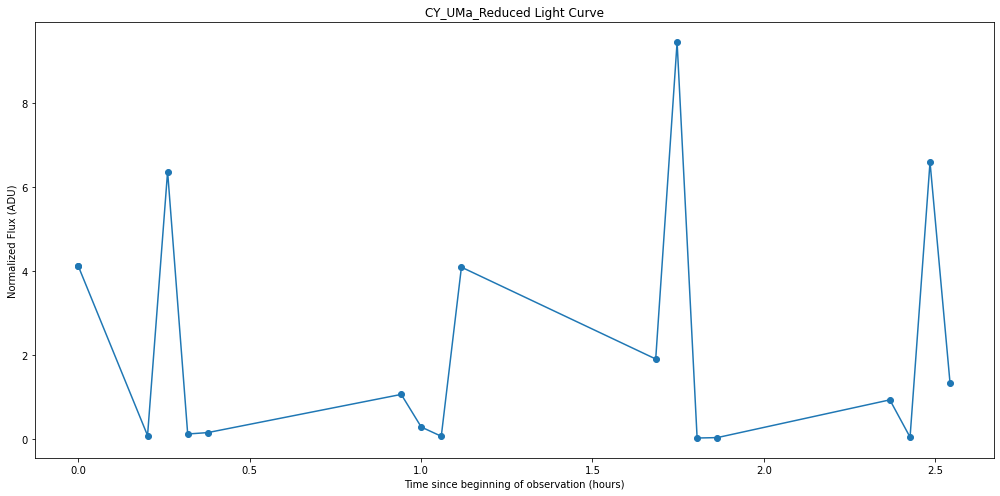

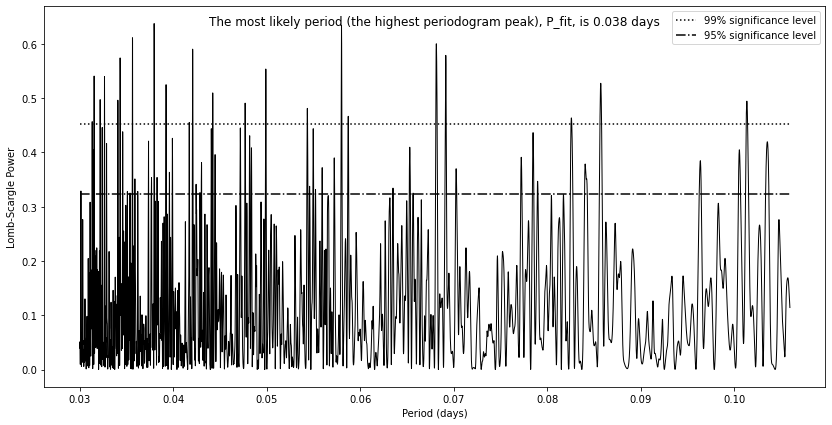

In [18]:
flux_table_CY_UMa = plot_light_curve(mypath = '/home/jovyan/work/CY_UMa_Reduced/', start_with='CY')
get_periodogram(t=flux_table_CY_UMa['hours'], y_obs=flux_table_CY_UMa['flux'], name='CY UMa')

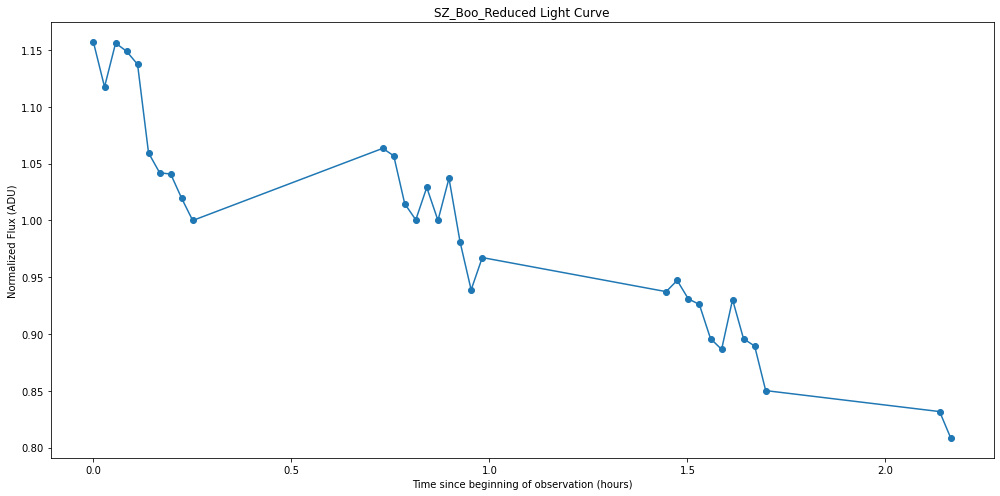

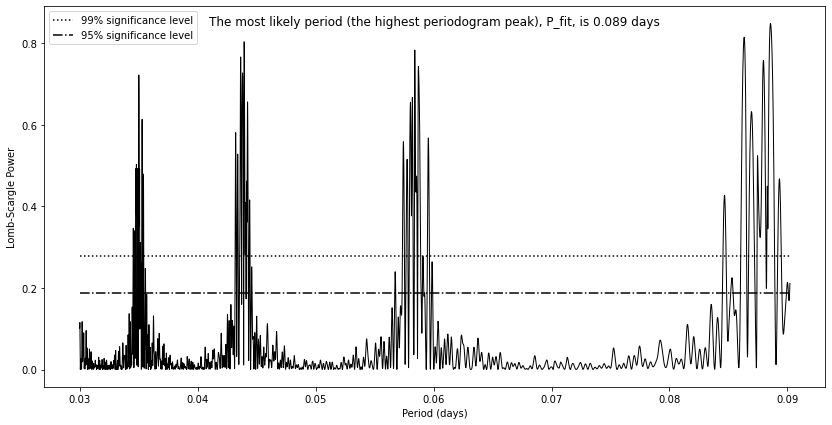

In [19]:
flux_table_SZ_Boo = plot_light_curve(mypath = '/home/jovyan/work/SZ_Boo_Reduced/', start_with='SZ Boo_V_')
get_periodogram(t=flux_table_SZ_Boo['hours'], y_obs=flux_table_SZ_Boo['flux'], name='SZ Boo')

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


All filters match: True
9.761427546423631 electron
1.2256616257811994 electron / adu


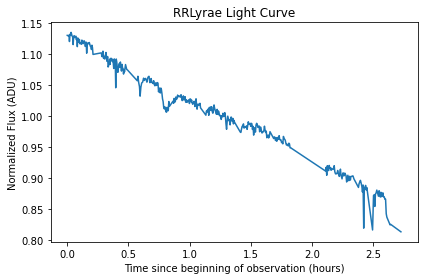

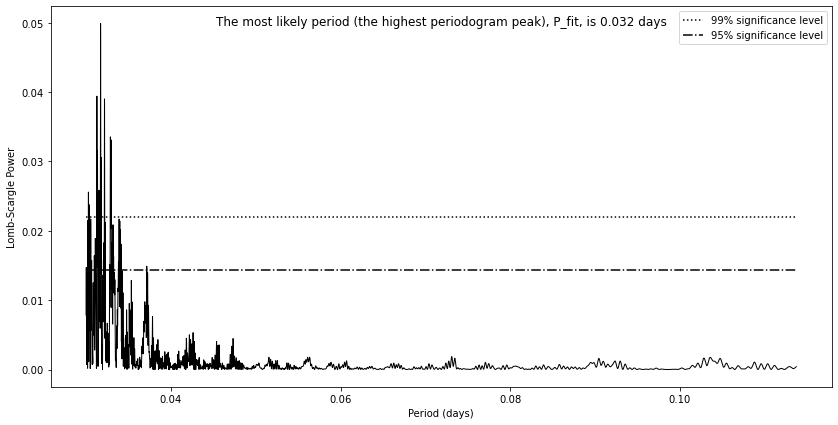

In [27]:
flux_table_RR_Lyrae = process_observations(zip_path='/home/jovyan/work/May 28 Observations-20250610T233053Z-1-001.zip', star="RRLyrae", flat_filter="domeflat_g", output_dir='/home/jovyan/work/paper-grachiel-new/src/')
get_periodogram(t=flux_table_RR_Lyrae['hours'], y_obs=flux_table_RR_Lyrae['flux'], name='RR Lyrae')
